In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch_geometric

from torch_geometric.utils import to_networkx
from torch_geometric.loader import NeighborLoader

import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import SAGEConv, GATConv, GATv2Conv, GCNConv, GlobalAttention
from torch_geometric.utils import dropout_edge

from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool
from torch_geometric.data import DataLoader

import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
import os
sys.path.insert(0, os.path.abspath('../../code/'))
from utils.graph_features import create_graph_dataset

In [3]:
import warrior as war

WARRIOR
   brain initialized
   network initialized


In [4]:
fcs = np.load('../local/fcs/sparse_fcs_100_unrelated.npy')
print(fcs.shape)
labels = np.load('../local/gender_labels/unrelated_gender_labels.npy')
print(labels.shape)

(852, 100, 100)
(852,)


In [5]:
N_GRAPHS = fcs.shape[0]
N_GRAPHS

852

In [6]:
PERCENT = 0.75 
N_TRAINING_SAMPLES = int(np.floor(PERCENT*N_GRAPHS))
N_TRAINING_SAMPLES, N_TRAINING_SAMPLES/N_GRAPHS

(639, 0.75)

In [7]:
root = '../local/graph_datasets/hcp/'
dataset = create_graph_dataset(sparse_fcs=fcs, root=root, labels=labels)

In [8]:
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

graph = dataset[0]
print()
print(f'First Graph: {graph}')
print('=============================================================')
print(f'Number of nodes: {graph.num_nodes}')
print(f'Number of edges: {graph.num_edges}')
print(f'Average node degree: {graph.num_edges / graph.num_nodes:.2f}')
print(f'Has isolated nodes: {graph.has_isolated_nodes()}')
print(f'Has self-loops: {graph.has_self_loops()}')
print(f'Is undirected: {graph.is_undirected()}')

Dataset: HCPDataset(852):
Number of graphs: 852
Number of features: 8
Number of classes: 2

First Graph: Data(x=[100, 8], edge_index=[2, 1332], edge_attr=[1332], y=[1])
Number of nodes: 100
Number of edges: 1332
Average node degree: 13.32
Has isolated nodes: False
Has self-loops: False
Is undirected: False


In [9]:
np.round(graph.x[:3,:].numpy(), 1)

array([[ 8. ,  8. ,  0. ,  4.4,  4.4,  0. ,  0. ,  0.7],
       [11. , 11. ,  0. ,  5.2,  5.2,  0. ,  0. ,  0.7],
       [25. , 22. ,  3. ,  9.3, 10.6, -1.3,  0.1,  0.5]], dtype=float32)

In [10]:
num_pos = sum(1 for data in dataset if data.y == 1)
num_neg = len(dataset) - num_pos
print(f'F:{num_pos} M:{num_neg} - {num_neg/num_pos:.3f}')

F:446 M:406 - 0.910


In [11]:
dataset_shuffled = dataset.shuffle()

train_dataset = dataset_shuffled[:N_TRAINING_SAMPLES]
test_dataset = dataset_shuffled[N_TRAINING_SAMPLES:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 639
Number of test graphs: 213


In [12]:
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)#, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)#, shuffle=False)
# for step, data in enumerate(train_loader):
#     print(f'Step {step + 1}:')
#     print('=======')
#     print(f'Number of graphs in the current batch: {data.num_graphs}')
#     print(data)
#     print(f'Graphs to aggregate: {len(np.unique(data.batch))}')
#     print(np.unique(data.batch))
#     print()

In [13]:
class AttentionGNN(torch.nn.Module):
    def __init__(self, hidden_channels, num_classes=2):
        super(AttentionGNN, self).__init__()

        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels) # SAGEConv, GATConv, GATv2Conv, GCNConv
        self.bn1 = torch.nn.BatchNorm1d(hidden_channels)
        self.dropout1 = torch.nn.Dropout(0.5)
        self.edge_drop = 0.3
        self.relu1 = nn.ReLU()

        self.attention_gate = nn.Sequential(
            #nn.Linear(hidden_channels, hidden_channels),
            #nn.ReLU(),
            #nn.BatchNorm1d(hidden_channels),
            nn.Linear(hidden_channels, 1),
            nn.ReLU()
            )
        
        self.attention_net = nn.Sequential(
            nn.Linear(hidden_channels, hidden_channels),
            #nn.BatchNorm1d(hidden_channels),
            #nn.Dropout(0.7),
            #nn.ReLU(),
            #nn.ReLU(),
            #nn.BatchNorm1d(hidden_channels),
        )

        self.global_attention = GlobalAttention(
            gate_nn=self.attention_gate,
            #nn=self.attention_net
        )

        self.classifier = nn.Sequential(
        nn.Linear(hidden_channels, hidden_channels // 2),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(hidden_channels // 2, 1),
        nn.ReLU(),
        #nn.Dropout(0.3),
        #nn.Linear(hidden_channels, 1),
        #nn.Dropout(0.2),
        #nn.ReLU(),
        )
    

    def forward(self, x, edge_index, batch):

        #edge_index, _ = dropout_edge(edge_index, p=self.edge_drop, training=self.training)
        
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = self.relu1(x)
        x = self.bn1(x)
        x = self.dropout1(x)

        
        #x = self.conv2(x, edge_index)
        graph_embedding = self.global_attention(x, batch)
        logits = self.classifier(graph_embedding)

        #torch.sigmoid(logits) 

        return logits


In [14]:
def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         data = data.to(device)
         optimizer.zero_grad()
         #print(f'Graphs in batch: {data.num_graphs}') 
         #print(f'data: {data}')
         y_logits = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         #print(y_logits.shape)
        
         #print(f'y_hat:{out.shape}')
         #print(out)
         y_logits = y_logits.to(device)
         loss = criterion(y_logits.float(), torch.unsqueeze(data.y.float().to(device),1))  # Compute the loss.
         loss.backward()  # Derive gradients.
         #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # # Prevent exploding gradients by clipping
         optimizer.step()  # Update parameters based on gradients.
         #optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         data = data.to(device)
         y_logits = model(data.x, data.edge_index, data.batch)
         y_probs = torch.sigmoid(y_logits)
         y_pred = (y_probs > 0.5).float()
         y_pred = y_pred.to(device)
         correct += int((y_pred.squeeze() == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

In [15]:
2**np.arange(10)

array([  1,   2,   4,   8,  16,  32,  64, 128, 256, 512])

In [16]:
EPOCHS = 8001
metrics = np.empty((2,EPOCHS))

model = AttentionGNN(hidden_channels=128)
optimizer = torch.optim.AdamW(model.parameters(),lr=0.0005,  weight_decay=1e-4, amsgrad=True)
#criterion = torch.nn.CrossEntropyLoss()
criterion = nn.BCEWithLogitsLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)

for epoch in range(EPOCHS):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    metrics[0,epoch] = train_acc
    metrics[1,epoch] = test_acc

    if epoch % 200 == 0:
        print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

cuda
Epoch: 000, Train Acc: 0.5681, Test Acc: 0.5164
Epoch: 200, Train Acc: 0.6745, Test Acc: 0.5399
Epoch: 400, Train Acc: 0.6604, Test Acc: 0.6009
Epoch: 600, Train Acc: 0.6698, Test Acc: 0.5258
Epoch: 800, Train Acc: 0.6823, Test Acc: 0.5869
Epoch: 1000, Train Acc: 0.7042, Test Acc: 0.5869
Epoch: 1200, Train Acc: 0.7027, Test Acc: 0.5681
Epoch: 1400, Train Acc: 0.7152, Test Acc: 0.5540
Epoch: 1600, Train Acc: 0.7042, Test Acc: 0.5634
Epoch: 1800, Train Acc: 0.7402, Test Acc: 0.5446
Epoch: 2000, Train Acc: 0.7199, Test Acc: 0.5634
Epoch: 2200, Train Acc: 0.7214, Test Acc: 0.5258
Epoch: 2400, Train Acc: 0.7340, Test Acc: 0.5211
Epoch: 2600, Train Acc: 0.7355, Test Acc: 0.5399
Epoch: 2800, Train Acc: 0.7214, Test Acc: 0.5540
Epoch: 3000, Train Acc: 0.7277, Test Acc: 0.5305
Epoch: 3200, Train Acc: 0.7543, Test Acc: 0.5258
Epoch: 3400, Train Acc: 0.7496, Test Acc: 0.5446
Epoch: 3600, Train Acc: 0.7449, Test Acc: 0.5540
Epoch: 3800, Train Acc: 0.7574, Test Acc: 0.5587
Epoch: 4000, Train A

(2, 8001)


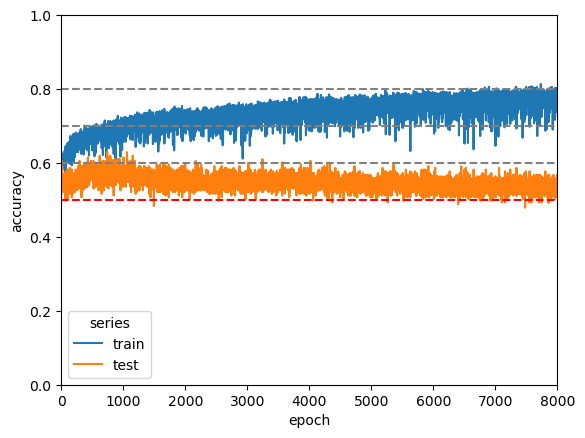

In [17]:
print(metrics.shape)
df = pd.DataFrame({'epoch': range(EPOCHS), 'train': metrics[0,:], 'test': metrics[1,:]})
df_melted = df.melt(id_vars='epoch', var_name='series', value_name='accuracy')
sns.lineplot(x='epoch', y='accuracy', hue='series', data=df_melted)
plt.plot([0,EPOCHS],[0.5,0.5], c='r', linestyle='--')
plt.plot([0,EPOCHS],[0.6,0.6], c='gray', linestyle='--')
plt.plot([0,EPOCHS],[0.7,0.7], c='gray', linestyle='--')
plt.plot([0,EPOCHS],[0.8,0.8], c='gray', linestyle='--')
plt.xlim(0,EPOCHS)
plt.ylim(0,1)
plt.show()